Some of the imports are not useful yet

In [2]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
import tensorflow as tf
from yaafelib import *

In [3]:
import csv
dataset_xs = []
dataset_y = []
with open('data/ismis.csv', 'rb') as csvfile:
    next(csvfile) # skip header
    reader = csv.reader(csvfile)
    for row in reader:
        features_strings = row[1:147] + row[168:191] 
        dataset_xs.append(map(float, features_strings)) # features
        dataset_y.append(row[-1]) # genre
    
classes = set(dataset_y)
nb_classes = len(classes)
mappings = dict(enumerate(classes))
mappings_rev = {v: k for k, v in mappings.items()}
dataset_y_mapped = map(lambda x: mappings_rev[x], dataset_y)

def evens(dataset):
    return dataset[::2]
def odds(dataset):
    return dataset[1::2]

train_dataset_xs = evens(dataset_xs)
train_dataset_y = evens(dataset_y_mapped)
test_dataset_xs = odds(dataset_xs)
test_dataset_y = odds(dataset_y_mapped)

def randomize(dataset_xs, dataset_y):
    permutation = np.random.permutation(len(dataset_y))
    shuffled_dataset_xs = np.asarray(dataset_xs)[permutation]
    shuffled_dataset_y = np.asarray(dataset_y)[permutation]
    return shuffled_dataset_xs, shuffled_dataset_y

train_dataset_xs, train_dataset_y = randomize(train_dataset_xs,train_dataset_y)
test_dataset_xs, test_dataset_y = randomize(test_dataset_xs, test_dataset_y)

try:
    f = open('data/ismis_randomized.pickle', 'wb')
    save = {
        'train_dataset_xs': train_dataset_xs,
        'train_dataset_y': train_dataset_y,
        'test_dataset_xs': test_dataset_xs,
        'test_dataset_y': test_dataset_y,
        'mappings': mappings
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [6]:
with open('data/ismis_randomized.pickle', 'rb') as f:
    save = pickle.load(f)
    train_dataset_xs = save['train_dataset_xs']
    train_dataset_y = save['train_dataset_y']
    test_dataset_xs = save['test_dataset_xs']
    test_dataset_y = save['test_dataset_y']
    del save  # gc

def oneHotEncoder(pos, max):
    encoded = []
    for i in range(0, max):
        if i == pos:
            encoded.append(1)
        else:
            encoded.append(0)
    return encoded
def reformat(dataset, labels):
    dataset = np.asarray(dataset).astype(np.float32)
    labels = map(lambda x: np.int32(x), labels)
    labels = map(lambda x: oneHotEncoder(x, 6), labels)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset_xs, train_dataset_y)
test_dataset, test_labels = reformat(test_dataset_xs, test_dataset_y)
print(train_dataset.shape)

(6248, 169)


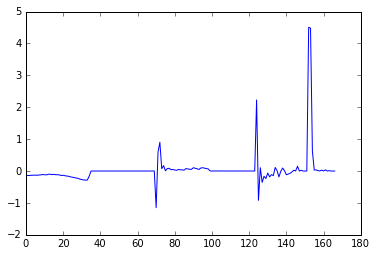

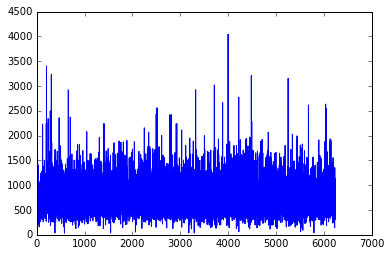

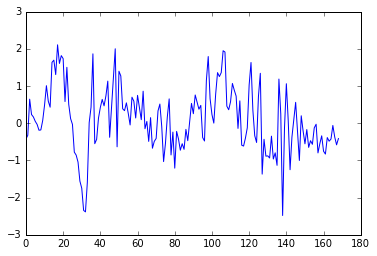

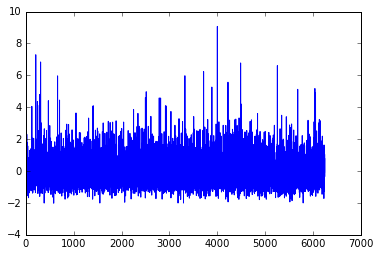

In [7]:
%matplotlib inline  

plt.plot(train_dataset[0,2:])
plt.show()

plt.plot(train_dataset[:,0])
plt.show()

mu = train_dataset.mean(axis=0)
sigma = train_dataset.std(axis=0)
train_dataset_scaled = (train_dataset - mu) / sigma
test_dataset_scaled = (test_dataset - mu) / sigma

plt.plot(train_dataset_scaled[0,:])
plt.show()

plt.plot(train_dataset_scaled[:,0])
plt.show()

In [31]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

batch_size = 128
num_labels = 6
num_features = 169
hidden_layer1_size = 1024
hidden_layer2_size = 256
hidden_lastlayer_size = 56

regularization_meta = 0.03

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_features))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset_scaled)
    keep_prob = tf.placeholder(tf.float32)

    weights_layer1 = tf.Variable(tf.truncated_normal([num_features, hidden_layer1_size], stddev=0.05))
    biases_layer1 = tf.Variable(tf.zeros([hidden_layer1_size]))

    weights_layer2 = tf.Variable(
        tf.truncated_normal([hidden_layer1_size, hidden_layer1_size], stddev=0.05))
    biases_layer2 = tf.Variable(tf.zeros([hidden_layer1_size]))

    weights_layer3 = tf.Variable(
        tf.truncated_normal([hidden_layer1_size, hidden_layer2_size], stddev=0.05))
    biases_layer3 = tf.Variable(tf.zeros([hidden_layer2_size]))

    weights_layer4 = tf.Variable(
        tf.truncated_normal([hidden_layer2_size, hidden_lastlayer_size], stddev=0.05))
    biases_layer4 = tf.Variable(tf.zeros([hidden_lastlayer_size]))

    weights = tf.Variable(tf.truncated_normal([hidden_lastlayer_size, num_labels], stddev=0.1))
    biases = tf.Variable(tf.zeros([num_labels]))

    def getNN4Layer(dSet, use_dropout):
        input_to_layer1 = tf.matmul(dSet, weights_layer1) + biases_layer1
        hidden_layer1_output = tf.nn.relu(input_to_layer1)

        logits_hidden1 = None
        if use_dropout:
            dropout_hidden1 = tf.nn.dropout(hidden_layer1_output, keep_prob)
            logits_hidden1 = tf.matmul(dropout_hidden1, weights_layer2) + biases_layer2
        else:
            logits_hidden1 = tf.matmul(hidden_layer1_output, weights_layer2) + biases_layer2

        hidden_layer2_output = tf.nn.relu(logits_hidden1)

        logits_hidden2 = None
        if use_dropout:
            dropout_hidden2 = tf.nn.dropout(hidden_layer2_output, keep_prob)
            logits_hidden2 = tf.matmul(dropout_hidden2, weights_layer3) + biases_layer3
        else:
            logits_hidden2 = tf.matmul(hidden_layer2_output, weights_layer3) + biases_layer3

        hidden_layer3_output = tf.nn.relu(logits_hidden2)
        logits_hidden3 = None
        if use_dropout:
            dropout_hidden3 = tf.nn.dropout(hidden_layer3_output, keep_prob)
            logits_hidden3 = tf.matmul(dropout_hidden3, weights_layer4) + biases_layer4
        else:
            logits_hidden3 = tf.matmul(hidden_layer3_output, weights_layer4) + biases_layer4

        hidden_layer4_output = tf.nn.relu(logits_hidden3)
        logits = None
        if use_dropout:
            dropout_hidden4 = tf.nn.dropout(hidden_layer4_output, keep_prob)
            logits = tf.matmul(dropout_hidden4, weights) + biases
        else:
            logits = tf.matmul(hidden_layer4_output, weights) + biases

        return logits

    logits = getNN4Layer(tf_train_dataset, True)
    logits_test = getNN4Layer(tf_test_dataset, False)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.3, global_step, 500, 0.90, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(logits_test)

    num_steps = 3001
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in xrange(num_steps):
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            batch_data = train_dataset_scaled[offset:(offset + batch_size)]
            batch_labels = train_labels[offset:(offset + batch_size)]

            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, keep_prob: 0.7}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 100 == 0):
                print("Minibatch loss at step", step, ":", l)
                print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction.eval(
                    feed_dict={tf_train_dataset: batch_data, tf_train_labels: batch_labels, keep_prob: 1.0}),
                                                              batch_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict={keep_prob: 1.0}), test_labels))

Initialized
Minibatch loss at step 0 : 1.79605
Minibatch accuracy: 36.7%
Minibatch loss at step 100 : 0.340509
Minibatch accuracy: 93.8%
Minibatch loss at step 200 : 0.190701
Minibatch accuracy: 98.4%
Minibatch loss at step 300 : 0.250634
Minibatch accuracy: 97.7%
Minibatch loss at step 400 : 0.208525
Minibatch accuracy: 99.2%
Minibatch loss at step 500 : 0.0995168
Minibatch accuracy: 99.2%
Minibatch loss at step 600 : 0.0743019
Minibatch accuracy: 100.0%
Minibatch loss at step 700 : 0.0732845
Minibatch accuracy: 100.0%
Minibatch loss at step 800 : 0.0881006
Minibatch accuracy: 99.2%
Minibatch loss at step 900 : 0.069698
Minibatch accuracy: 100.0%
Minibatch loss at step 1000 : 0.0450861
Minibatch accuracy: 100.0%
Minibatch loss at step 1100 : 0.137064
Minibatch accuracy: 98.4%
Minibatch loss at step 1200 : 0.0129459
Minibatch accuracy: 100.0%
Minibatch loss at step 1300 : 0.00895182
Minibatch accuracy: 100.0%
Minibatch loss at step 1400 : 0.0126482
Minibatch accuracy: 100.0%
Minibatch 